In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.integrate import ode
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from mpl_toolkits import axes_grid1

In [2]:
a= 5
b= 500
xx = np.linspace(-a, a, b)
yy = np.linspace(-a, a, b)
mX, mY = np.meshgrid(xx,yy)

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{dsfont}'
})

In [4]:
r0=np.array([0,.5])            # position of the force red arrow - touchdown point
f=np.array([0,-1])             # direction of the force

def stokeslet(f,r0,mX,mY):
    Id=np.array([[1,0],[0,1]])
    r=np.array([mX-r0[0],mY-r0[1]])

    Idf=np.dot(Id,f) 
    
    rTf=(r*f[:,np.newaxis,np.newaxis]).sum(axis=0)
    rrTf=(r*rTf[np.newaxis,])
    modr=(r[0]**2+r[1]**2)**.5
    
    u,v=Idf[:,np.newaxis,np.newaxis]/modr+rrTf/modr**3.
    return [u,v]

u,v=stokeslet(f,r0,mX,mY)
f1=-f

r1=np.array([0,-.5])



u1,v1=stokeslet(f1,r1,mX,mY)

u = u + u1
v = v + v1


In [5]:

xstart = np.linspace(-0.99*a, 0.99*a, 10)
ystart =np.zeros(10)

k=0
for i in ystart:
    k+=1
    ystart[:k]= 0.99*a


places=np.vstack([xstart,ystart]).T
# interpolate function of the Bx and Bz as functions of (x,z) position
fbx = interpolate.interp2d(xx,yy,u)
fbz = interpolate.interp2d(xx,yy,v)

def B_dir(t,p,fx,fz):
    ex = fx(p[0],p[1])
    ez = fz(p[0],p[1])
    n = (ex**2+ez**2)**0.5
    return [ex/n, ez/n]


In [6]:
R=0.001
dt=0.8*R

# plot area
x0, x1= -0.99*a, 0.99*a
y0, y1= -0.99*a, 0.99*a

#set the ode function
r=ode(B_dir)
r.set_integrator('vode')
r.set_f_params(fbx,fbz)

xs,ys = [],[]
for p in places:
    x=[p[0]] 
    y=[p[1]]
    r.set_initial_value([p[0], p[1]], 0)
    while r.successful():
        r.integrate(r.t+dt)
        x.append(r.y[0])
        y.append(r.y[1])
        hit_electrode=False
        #check if field line left drwaing area
        if (not (x0<r.y[0] and r.y[0]<x1)) or (not (y0<r.y[1] and r.y[1]<y1)):
            break
    xs.append(x)
    ys.append(y)
    
nxs,nys = [],[]
for p in places:
    x=[p[0]] 
    y=[-p[1]]
    r.set_initial_value([p[0], p[1]], 0)
    while r.successful():
        r.integrate(r.t+dt)
        x.append(r.y[0])
        y.append(-r.y[1])
        hit_electrode=False
        #check if field line left drwaing area
        if (not (x0<r.y[0] and r.y[0]<x1)) or (not (y0<r.y[1] and r.y[1]<y1)):
            break
    nxs.append(x)
    nys.append(y)

12634


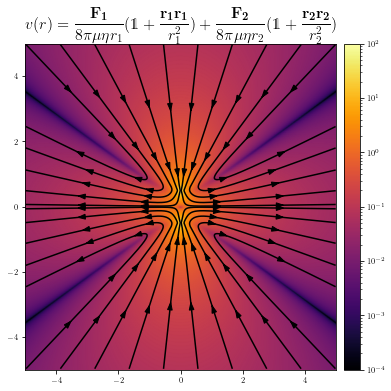

In [8]:
fig=plt.figure(figsize=(6,6),facecolor="w")
ax = plt.axes()

p, result = [], []
for x in xs:
    p.append(len(x))

[result.append(x) for x in p if x not in result]

result.sort()
k = result[-1]

h = int(k/5)
for x,y in zip(xs,ys):
    ax.plot(x,y, color="k" , zorder=10)
    
    ax.arrow(x[3*h], y[3*h], x[3*h-1]-x[3*h-2], y[3*h+2]-y[3*h+1], length_includes_head=True, head_width=.15, color="k", zorder=5)
    ax.arrow(x[h], y[h], x[h-1]-x[h-2], y[h+5]-y[h+4], length_includes_head=True, head_width=.15, color="k", zorder=5)
    ax.arrow(x[2*h], y[2*h], x[2*h-1]-x[2*h-2], y[2*h+5]-y[2*h+4], length_includes_head=True, head_width=.15, color="k", zorder=5)
    ax.arrow(x[4*h], y[4*h], (x[4*h-1]-x[4*h-2]), (y[4*h+5]-y[4*h+4]), length_includes_head=True, head_width=.15, color="k", zorder=5)
    
for x,y in zip(nxs,nys):
    ax.plot(x,y, color="k", zorder=10 )
    
    ax.arrow(x[3*h], y[3*h], x[3*h-1]-x[3*h-2], y[3*h+5]-y[3*h+4], length_includes_head=True, head_width=.15, color="k", zorder=5)
    ax.arrow(x[h], y[h], x[h-1]-x[h-2], y[h+5]-y[h+4], length_includes_head=True, head_width=.15, color="k", zorder=5)
    ax.arrow(x[2*h], y[2*h], x[2*h-1]-x[2*h-2], y[2*h+5]-y[2*h+4], length_includes_head=True, head_width=.15, color="k", zorder=5)
    ax.arrow(x[4*h], y[4*h], x[4*h-1]-x[4*h-2], y[4*h+5]-y[4*h+4], length_includes_head=True, head_width=.15, color="k", zorder=5)
    
Z = np.sqrt(v**2+u**2)


image = ax.pcolormesh(mX, mY, Z,
                norm=colors.LogNorm(vmin= 10**(-4), vmax=10**2),
                #norm=colors.LogNorm(vmin= 10**(-1), vmax=10**1),
                #norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()), 
                      snap=True,
               cmap=plt.cm.inferno, rasterized=True, 
               shading='gouraud', zorder=0)


def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)


add_colorbar(image)
ax.set_title(r'$\displaystyle\\v(r)='
             r'\frac{\mathbf{F_1}}{8 \pi \mu \eta r_1 } ( \mathds{1} + \frac{\mathbf{r_1 r_1}}{r_1^2}) + \frac{\mathbf{F_2}}{8 \pi \mu \eta r_2 } ( \mathds{1} + \frac{\mathbf{r_2r_2}}{r_2^2})$', fontsize=16, color='k')

plt.savefig('dipole_sum_good_one.pdf', bbox_inches='tight', pad_inches=0, dpi=400)
# dpi=4000 to make everything 'in shape'... but it lasts ages'''

